this file contains what I think is the most appropriate result thus far, I had some issues in previous files with power and energy conversions that I think I have resolved here. 

Module imports

In [1]:
# module loads
import os
import re
import numpy as np
import pandas as pd

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG,
                    format=' %(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

logging.disable(0) # switched debug on. 
logging.disable(logging.DEBUG) # debug and below not reported.
# logging.disable(logging.INFO)
# logging.disable(logging.WARNING)
# logging.disable(logging.ERROR)
# logging.disable(logging.CRITICAL)

In [3]:
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 

In [4]:
# from bokeh.io import push_notebook
# from bokeh.plotting import figure, output_file, show

# # from bokeh.plotting import figure, show, output_file
# from bokeh.layouts import row, column

In [5]:
from collections import defaultdict
from datetime import timedelta, datetime, date, time
import csv

In [6]:
import UniSA_CNC_BasisData as UniSA_data
from Get_NEM_PV_forecast import get_PV_forecast, load_PV_forecast_meta_data
from Get_NEM_forecasts import get_RRP_forecast
from Get_NEM_Zip_Archive import update_zips
%reload_ext autoreload
%autoreload 2

_ = load_PV_forecast_meta_data()

 2018-07-30 10:20:04,830 - INFO - About to load keys for forecasts


### Utility functions 

In [7]:
minutes_to_seconds = lambda m: m * 60.0 
seconds_to_minutes = lambda s: s / 60.0 

seconds_to_hours = lambda s: s / 3600.0 
hours_to_seconds = lambda h: h * 3600.0 

Joules_to_WattHours = lambda J: J / 3600.0
WattHours_to_Joules = lambda Wh: Wh * 3600.0

to_energy   = lambda W,t: W * t 
to_power    = lambda J,t: J / t 

from_kiloUnit = lambda U: U * 1.0e3
from_megaUnit = lambda U: U * 1.0e6
from_gigaUnit = lambda U: U * 1.0e9

to_kiloUnit = lambda U: U / 1.0e3
to_megaUnit = lambda U: U / 1.0e6
to_gigaUnit = lambda U: U / 1.0e9

def get_percent(comp, base):
    if base != 0.0: return comp/base
    return 0.0

ghi_to_pv = lambda ghi, pv_size: ghi * pv_size

In [8]:
def get_files_matching(src_dir, regx):
    fn_list = []
    for fn in os.listdir(src_dir): fn_list.append(fn) if re.match(regx, fn) else None
    fn_list.sort()
    return (fn_list)

In [9]:
is_weekday = lambda ts: ts.dayofweek in {0, 1, 2, 3, 4}
is_in_peakperiod = lambda ts: ts.time() in pd.date_range(start='12:00', end='21:00', 
                                                       freq='30T', closed='right', label='right')
is_peak = lambda v: is_weekday(v) and is_in_peakperiod(v)

# Load the source data:

In [10]:
ORIGINAL_SOURCE_DATA_FILE = './data/all_together.csv'

In [11]:
LOAD_DF = pd.read_csv(ORIGINAL_SOURCE_DATA_FILE, index_col=0, infer_datetime_format=True, dayfirst=True)

logger.info('Source data loaded, with first entry:\n%s', LOAD_DF.head(3))
logger.info('ending in \n%s', LOAD_DF.tail(3))
# other debug traces for sanity checks:
logger.debug('Maximum incident GHI value: {:.2f} at time {:}'.format(
    LOAD_DF.GHI_kWpm2.max(), LOAD_DF.GHI_kWpm2.argmax()))


 2018-07-30 10:20:14,312 - INFO - Source data loaded, with first entry:
                       MSB_F_kW  Frig_9_kW    RRP   GHI_kWpm2
2017-10-13 14:30:00  135.972210  62.650850  88.84  721.174000
2017-10-13 15:00:00  207.161339  92.003353  83.76  640.414333
2017-10-13 15:30:00  184.389458  23.948075  86.81  538.250000
 2018-07-30 10:20:14,315 - INFO - ending in 
                       MSB_F_kW  Frig_9_kW    RRP  GHI_kWpm2
2018-01-31 22:30:00  184.577797  58.381405  65.23        0.0
2018-01-31 23:00:00  187.425644  64.568821  60.23        0.0
2018-01-31 23:30:00  233.711525  63.303780  63.51        0.0


Time span of interest:

In [12]:
START_TIMES = [LOAD_DF.iloc[0].name]
END_TIMES = [LOAD_DF.iloc[-1].name]

TES parameterisation:

In [13]:
TES_pack_size = 1040 # kWh_r
TES_pack_min_heating= -200 # kW_r
TES_pack_max_heating = 200 # kW_r

# use this for a range of strorage sizes.
# storage_sizes = np.arange(5,16,1) * TES_pack_size

STORAGE_SIZES = np.array([2080])
PV_SIZE = 0.250 # MW


### Generating parameters for use with optimal control of thermal energy storage

some demand price dags

as the monthly bill is $ \Pi_d = \pi_d\ D\ G_{max} $ where $D$ is the number of days in the month and $G_{max}$ is the maximum demand for the month

I propose a proxy for $\pi_d$, $\hat\pi_d$ as follows:

if the maximum demand were incurred during all intervals then the demand cost would be

$\Pi_d = \pi_d\ D\ G_{max}$, 

but if we calculate the demand penalty during one interval with a $\hat\pi_d G_{max}^{2}$ term, for the value $\Pi_d$ to be incurred as a penalty at the end of the month we have 

$\hat\pi_d G_{max}^{2} \times (48D) = \Pi_d$ 

$\hat\pi_d G_{max}^{2}\ 48\ D = \pi_d\ D\ G_{max}$ 

$\hat\pi_d G_{max}\ 48 = \pi_d$ 

$\hat\pi_d = \pi_d \div 48 G_{max}$ 


Now I tried this and $\hat\pi_d$ was so small that I could not see it.  So I changed $G_{max}$ units form kVA to kJ/s reactive just for giggles. 

now because $\lambda = \frac{2 \pi_d (P_{max} - S + L) + \pi_i}{\kappa}$ when optimum we want to see this in the plot and have the $2 \pi_d (P_{max} - S + L)$ term value in the ball park of $\pi_i$

In [14]:
logger.info(' maximum deman VA using 0.97 pf: {:.2f} kVA at time {:}'.format(
    LOAD_DF.MSB_F_kW.max()/0.97, LOAD_DF.MSB_F_kW.argmax()))

 2018-07-30 10:20:14,849 - INFO -  maximum deman VA using 0.97 pf: 421.29 kVA at time 2017-11-21 15:30:00


In [15]:
Max_kVA = 425 
Demand_scaling = 2 * 48 * Max_kVA / 3.6e3  ### $ per kJ reactive

PEAK_DEMAND_COST =  0.2321 / Demand_scaling 
# PEAK_DEMAND_COST = 0.0
OFF_PEAK_DEMAND_COST = 0.1190 / Demand_scaling
# OFF_PEAK_DEMAND_COST = 0.0

calculate import and export costs

In [16]:
EXPORT_PERCENT = 0.90

PPPT_LF = 1.05087 # for pull through contract 
GEN_LF = 1.04700 # for xREC and AEMO fee adjustment 

SERVICE_COSTS = ( # in c/kWh 
          (0.2250 * PPPT_LF)# PPPT admin fee 
        + (1.3499 * GEN_LF)# LRECs
        + (0.3603 * GEN_LF)# SRECs
        + (0.0243 * 100 )# SAPN HV- usage cost ($/kWh -> c/kWh)
        + (0.0281 * GEN_LF)# AEMO ancillary fee
        + (0.0341 * GEN_LF))# AEMO market fee 

logger.info('service costs: {:.4f} c/kWh'.format(SERVICE_COSTS))    

 2018-07-30 10:20:15,199 - INFO - service costs: 4.5221 c/kWh


calculate the maximum compressor power

In [17]:
# for a compressor at max 155 kWe at input with CoP 3.5-4.2
MAX_COP = 4.2
MIN_COP = 3.5

MAX_COMPRESSOR_PWR_kWe = 155
MAX_COMPRESSOR_PWR_kWr = MAX_COMPRESSOR_PWR_kWe * MAX_COP

logger.info('calculated maximum compressor output {:.1f} kW_r'.format(MAX_COMPRESSOR_PWR_kWr))

 2018-07-30 10:20:15,386 - INFO - calculated maximum compressor output 651.0 kW_r


## Generating the basis data ... 

In [18]:
FOCUS_DF = pd.DataFrame()

the values should be set using average power values given in the original dataset. In case they are not, I have a flag for that.

In [19]:
usePowerValues = True

if not usePowerValues: # convert to energy values
    FOCUS_DF['L_r'] = to_energy(LOAD_DF.Frig_9_kW*MAX_COP, 0.5)
    FOCUS_DF['CoP'] = MAX_COP
    raw_L_e = LOAD_DF.MSB_F_kW - LOAD_DF.Frig_9_kW
    raw_L_e = raw_L_e.where(raw_L_e > 0.0, 0.0)
    FOCUS_DF['L_e'] = to_energy(raw_L_e, 0.5)
    FOCUS_DF['PV'] = to_energy(ghi_to_pv(LOAD_DF.GHI_kWpm2, 0.250), 0.5)
else: 
    FOCUS_DF['L_r'] = LOAD_DF.Frig_9_kW*MAX_COP
    FOCUS_DF['CoP'] = MAX_COP
    raw_L_e = LOAD_DF.MSB_F_kW - LOAD_DF.Frig_9_kW
    raw_L_e = raw_L_e.where(raw_L_e > 0.0, 0.0)
    FOCUS_DF['L_e'] = raw_L_e
    FOCUS_DF['PV'] = ghi_to_pv(LOAD_DF.GHI_kWpm2, 0.250)

In [20]:
# 1/10 factor is for converting from $/MWh to c/kWh
adjust_import_cost = lambda rrp: PPPT_LF/10.0*rrp + SERVICE_COSTS
adjust_export_price = lambda rrp, percent: percent/10.0*rrp
adjust_export_price_standalone = lambda rrp: adjust_export_price(rrp, 0.9)

adjust_import_cost_dpkWh = lambda rrp: (PPPT_LF/10.0*rrp + SERVICE_COSTS) / 100
adjust_export_price_standalone_dpkWh = lambda rrp: adjust_export_price(rrp, 0.9) / 100

worried about this next bit .. am I using the right price data?

In [21]:
FOCUS_DF['adj_cpkWh'] = adjust_import_cost(LOAD_DF.RRP)
FOCUS_DF['exp_cpkWh'] = adjust_export_price(LOAD_DF.RRP, 0.90)
FOCUS_DF['tou_cpkWh'] = 0.0

reindex with datetimes

In [22]:
FOCUS_DF.index = pd.to_datetime(FOCUS_DF.index)

In [23]:
logger.info('Source data focussed, with first entry:\n%s', FOCUS_DF.head(3))
logger.info('\nending in \n%s', FOCUS_DF.tail(3))

 2018-07-30 10:20:16,548 - INFO - Source data focussed, with first entry:
                            L_r  CoP         L_e          PV  adj_cpkWh  \
2017-10-13 14:30:00  263.133569  4.2   73.321360  180.293500  13.858078   
2017-10-13 15:00:00  386.414083  4.2  115.157986  160.103583  13.324236   
2017-10-13 15:30:00  100.581915  4.2  160.441383  134.562500  13.644751   

                     exp_cpkWh  tou_cpkWh  
2017-10-13 14:30:00     7.9956        0.0  
2017-10-13 15:00:00     7.5384        0.0  
2017-10-13 15:30:00     7.8129        0.0  
 2018-07-30 10:20:16,553 - INFO - 
ending in 
                            L_r  CoP         L_e   PV  adj_cpkWh  exp_cpkWh  \
2018-01-31 22:30:00  245.201900  4.2  126.196392  0.0  11.376974     5.8707   
2018-01-31 23:00:00  271.189048  4.2  122.856823  0.0  10.851539     5.4207   
2018-01-31 23:30:00  265.875874  4.2  170.407745  0.0  11.196224     5.7159   

                     tou_cpkWh  
2018-01-31 22:30:00        0.0  
2018-01-31 23:00:00 

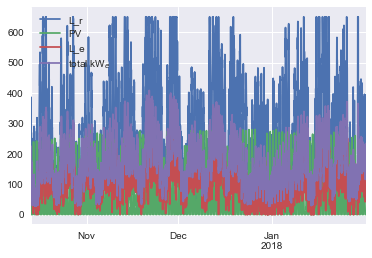

In [24]:
FOCUS_DF.L_r.plot()
FOCUS_DF.PV.plot()
FOCUS_DF.L_e.plot()
(FOCUS_DF.L_r/FOCUS_DF.CoP + FOCUS_DF.L_e).plot(label='total kW$_e$')
plt.legend()
plt.show()

### generate input files for optimisation 

In [25]:
long_column_names = ['thermal load (kWr)', 'electrical load (kWe)', 'solar (kWe)', 'CoP', 
                     'import price ($/kWh)', 'export price ($/kWh)', 'demand price ($/kW)']
short_column_names = ['L_r', 'L_e', 'PV', 'CoP', 'pi_i', 'pi_e', 'pi_d']

COLUMN_NAMES = defaultdict(list)
COLUMN_NAMES = {key:val for key, val in zip(short_column_names, long_column_names)}

In [26]:
def get_analysis_period(Start, End):
    """Calculates the PV output for a given GHI value
        at the moment just a simple scaling, later could make it angle of 
        incidence dependent.
    """
    start_date = pd.to_datetime(Start)
    end_date = pd.to_datetime(End)

    period_range = pd.date_range(start=start_date, end=end_date, freq='30T', closed=None, label='right', name='time')
    logger.info(period_range)
    
    return (period_range, start_date, end_date)

In [27]:
USE_TOU = False # flag to implement Time of Use energy tariff
NO_PV = False # switching the PV off

for storage_size in STORAGE_SIZES:
        
    tsv_data_dir = './data/tsv_TES_{:n}'.format(storage_size)
    if not os.path.exists(tsv_data_dir): os.mkdir(tsv_data_dir)
        
    for iniz, fine in zip(START_TIMES, END_TIMES):
        logger.info('preparing data range from %s to %s', iniz, fine)
        (ANALYSIS_PERIOD, START_DATE, END_DATE) = get_analysis_period(iniz, fine)
            
        # make an internal copy of the required data here
        test = FOCUS_DF[['L_r', 'L_e', 'PV', 'adj_cpkWh', 'exp_cpkWh', 'tou_cpkWh']].loc[ANALYSIS_PERIOD].copy()
        
        # reset the Renewable energy input if desired
        if NO_PV: test.PV = 0.0 
        
        # for sinusoidal cop with time of use tariff
        time_of_day_minutes = test.index.hour * 60 + test.index.minute
        peak_CoP_time_minutes = 6.5 * 60  # 06:30 am 
        deltas = time_of_day_minutes - peak_CoP_time_minutes
        timebase = 24 * 60 
        omega = deltas / timebase * 2 * np.pi

        test['CoP'] = (MAX_COP - MIN_COP) * (np.cos(omega) + 1) + MIN_COP
        # or something simpler
#         test['CoP'] = MAX_COP
        
        if USE_TOU:
            test['pi_i'] = test.tou_cpkWh / 100.0 # $/kWh
            test['pi_e'] = 0.08 # $/kWh
        else:
            # for simple cop with pull through contract 
            test['pi_i'] = test.adj_cpkWh / 100.0 # $/kWh
            test['pi_e'] = test.exp_cpkWh / 100.0 # $/kWh

            
        # set up the demand prices 
        test['pi_d'] = OFF_PEAK_DEMAND_COST # set up the series
        for i, v in test.pi_d.items():
            test.pi_d.set_value(i, PEAK_DEMAND_COST) if is_peak(i) else test.pi_d.set_value(i, OFF_PEAK_DEMAND_COST)

        # now the data is set up, clean up and create an input file ...
        test.fillna(0, inplace=True)
        test.drop_duplicates(keep='first', inplace=True)
        test.drop(['adj_cpkWh', 'exp_cpkWh', 'tou_cpkWh'], axis=1, inplace=True)
        test.rename(columns=COLUMN_NAMES, inplace=True)

        
        
        tsv_file_name = 'test_data_{:n}.tsv'.format(storage_size)
        tsv_file_name = os.path.join(tsv_data_dir, tsv_file_name)  

        meta_data = [('thermal storage capacity (kWh)', storage_size)]
        meta_data.append(('minimum storage heating rate (kW)', 
                          TES_pack_min_heating * storage_size / TES_pack_size))
        meta_data.append(('maximum storage heating rate (kW)', 
                          TES_pack_max_heating * storage_size / TES_pack_size))
        meta_data.append(('maximum compressor electrical power (kW)', MAX_COMPRESSOR_PWR_kWe))   
        meta_data.append(('initial thermal store state (kWh)', storage_size/2.0))
        meta_data.append(('final thermal store state (kWh)', storage_size/2.0))

        # do the do ...   
        with open(tsv_file_name, 'w', newline='') as out_tsv:
            logger.debug('updating parameters with:\n%s', meta_data)
        
            csv_write = csv.writer(out_tsv, delimiter='\t', lineterminator='\n')
            for row in meta_data: csv_write.writerow(row)
            csv_write.writerow([]) # empty row as a spacer
        
        test.to_csv(tsv_file_name, mode='a', sep='\t')

 2018-07-30 10:20:18,995 - INFO - preparing data range from 2017-10-13 14:30:00 to 2018-01-31 23:30:00
 2018-07-30 10:20:18,997 - INFO - DatetimeIndex(['2017-10-13 14:30:00', '2017-10-13 15:00:00',
               '2017-10-13 15:30:00', '2017-10-13 16:00:00',
               '2017-10-13 16:30:00', '2017-10-13 17:00:00',
               '2017-10-13 17:30:00', '2017-10-13 18:00:00',
               '2017-10-13 18:30:00', '2017-10-13 19:00:00',
               ...
               '2018-01-31 19:00:00', '2018-01-31 19:30:00',
               '2018-01-31 20:00:00', '2018-01-31 20:30:00',
               '2018-01-31 21:00:00', '2018-01-31 21:30:00',
               '2018-01-31 22:00:00', '2018-01-31 22:30:00',
               '2018-01-31 23:00:00', '2018-01-31 23:30:00'],
              dtype='datetime64[ns]', name='time', length=5299, freq='30T')


# Baseline result
here we put all the data trough the ringer and get a baseline result

I might ger around to generating a panel from the swath of input files for a range of storage sizes.

In [28]:
logger.info('start of baseline optimisation')
os.system('cooling.exe ./data/tsv_TES_2080/test_data_2080 ./data/tsv_TES_2080/test_data_2080_output')
logger.info('end of baseline optimisation')

 2018-07-30 10:20:21,149 - INFO - start of baseline optimisation
 2018-07-30 10:21:03,112 - INFO - end of baseline optimisation


### process the baseline data 

In [29]:
baseline_rf = pd.read_csv('./data/tsv_TES_2080/test_data_2080_output.tsv', sep='\t', 
                 index_col=0, infer_datetime_format=True)

# fix up the index ...
baseline_rf.index = pd.to_datetime(baseline_rf.index)

# do some global colum stuff: 
output_columns_long = baseline_rf.columns # save them for now
output_columns_short = ['L_kWr', 'L_kWe', 'S_kWe', 'CoP', 'pi_i', 'pi_e', 'pi_d', # inputs  
                        'lambda_dpkWh', 'mode', 'P_kWe', 'G_kWe', 'SoC_kWhr', 'C_kWr'] # outputs
OUTPUT_COLUMN_NAMES = defaultdict(list)
OUTPUT_COLUMN_NAMES = {key:val for key, val in zip(output_columns_long, output_columns_short)}
OUTPUT_COLUMN_ALIAS = {val:key for key, val in zip(output_columns_long, output_columns_short)}

logger.debug('Column dictionary is: \n%s', OUTPUT_COLUMN_NAMES)
logger.debug('or the backward lookup: \n%s', OUTPUT_COLUMN_ALIAS)

In [30]:
logger.debug('old coulumn names: %s', baseline_rf.columns)
baseline_rf.rename(columns=OUTPUT_COLUMN_NAMES, inplace=True)
logger.info('new coulumn names: %s', baseline_rf.columns)

 2018-07-30 10:21:03,795 - INFO - new coulumn names: Index(['L_kWr', 'L_kWe', 'S_kWe', 'CoP', 'pi_i', 'pi_e', 'pi_d',
       'lambda_dpkWh', 'mode', 'P_kWe', 'G_kWe', 'SoC_kWhr', 'C_kWr'],
      dtype='object')


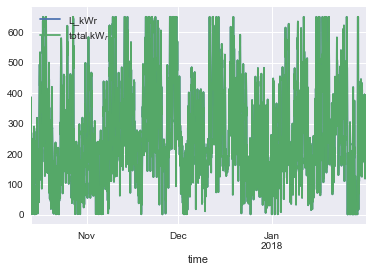

In [31]:
baseline_rf.L_kWr.plot()
(baseline_rf.P_kWe*baseline_rf.CoP + baseline_rf.C_kWr).plot(label='total kW$_r$')
plt.legend()
plt.show()

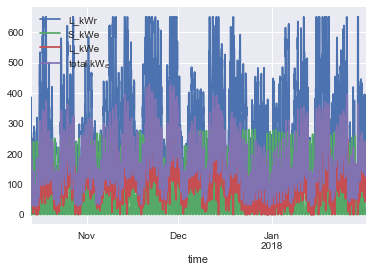

In [32]:
baseline_rf.L_kWr.plot()
baseline_rf.S_kWe.plot()
baseline_rf.L_kWe.plot()
(baseline_rf.L_kWr/baseline_rf.CoP + baseline_rf.L_kWe).plot(label='total kW$_e$')
plt.legend()
plt.show()

# The visualisation code

In [33]:
from bokeh.plotting import ColumnDataSource, figure
from bokeh.io import output_file, show
# import the HoverTool
from bokeh.models import HoverTool
from bokeh.layouts import column

def get_datetime_str():
    return pd.datetime.strftime(pd.datetime.now(), '%Y-%m-%d_%H%M')

def plot_result_df(rf):
    # set some special plotting columns
    rf['_SoC_kWhr'] = rf.SoC_kWhr.max() - rf.SoC_kWhr
    rf['_S_kWe'] = -1.0 * rf.S_kWe
    rf['G_in_kWe'] = rf.G_kWe.where(rf.G_kWe > 0.0, 0.0)
    rf['G_out_kWe'] = rf.G_kWe.where(rf.G_kWe < 0.0, 0.0)
    rf['L_kWr2e'] = rf.L_kWr / 4.5
    rf['G_kWe_orig'] = rf.L_kWr2e + rf.L_kWe
    rf['Net_kWe'] = rf.L_kWe + rf._S_kWe

    _priceScaling = 5.0e2
    _priceScaling = 4.0e2
    rf['plt_lambda'] = -1.0 * rf.lambda_dpkWh * _priceScaling
    rf['plt_cost'] = rf.pi_i / rf.CoP * _priceScaling
    rf['plt_cost_croptop'] = rf.plt_cost.where(rf.plt_cost < rf.SoC_kWhr.max(), rf.SoC_kWhr.max())
    rf['plt_price'] = rf.pi_e / rf.CoP * _priceScaling
    rf['plt_price_croptop'] = rf.plt_price.where(rf.plt_price < rf.SoC_kWhr.max(), rf.SoC_kWhr.max())
    
    source = ColumnDataSource(rf)
    
    _plotWidth = 800
    _plotHeight = 600
    _barWidth = 1.0e6
    _Tools ='pan,box_zoom,wheel_zoom,box_select,save,reset,help'
    
    s1 = figure(tools=_Tools, plot_width=_plotWidth, plot_height=_plotHeight, 
                 x_axis_type='datetime', toolbar_location='above')
    s1.yaxis.axis_label = 'Electrical loads'
    s1.xaxis.axis_label = 'Date and time'
        
    s2 = figure(tools=_Tools, plot_width=_plotWidth, plot_height=_plotHeight, 
                x_axis_type='datetime', toolbar_location='above')
    s2.yaxis.axis_label = 'Storage state and switching price'
    s2.xaxis.axis_label = 'Date and time'
   
    s1.vbar(x='time', top='_S_kWe', source=source,
            width=_barWidth, alpha=1.0, 
            color='orange', legend=OUTPUT_COLUMN_ALIAS['S_kWe'], 
            selection_color='orange', selection_alpha=1.0, 
            nonselection_color='orange', nonselection_alpha=0.1
           )
    s1.vbar(x='time', top='G_kWe', source=source,
            width=_barWidth, alpha=0.7, 
            color='firebrick', legend=OUTPUT_COLUMN_ALIAS['G_kWe'],
            selection_color='firebrick', selection_alpha=1.0, 
            nonselection_color='firebrick', nonselection_alpha=0.1
           )
    s1.vbar(x='time', top='P_kWe', source=source,
            width=_barWidth, alpha=0.5,
            color='navy', legend=OUTPUT_COLUMN_ALIAS['P_kWe'],
            selection_color='navy', selection_alpha=1.0, 
            nonselection_color='navy', nonselection_alpha=0.1
           )
    s1.line(x='time', y='L_kWr2e', source=source,
            color="aqua", legend='original thermal load (kW)',
            selection_color="aqua", selection_alpha=1.0, 
            nonselection_color="aqua", nonselection_alpha=0.1
           )
#     s1.line(x='time', y='G_kWe_orig', source=source,
#             color="orange", legend='original grid load (kW)')
#     s1.line(x='time', y='Net_kWe', source=source,
#             color="lightgray", legend='net electrical load (kW)')
        
    s2 = figure(tools=_Tools, plot_width=_plotWidth, plot_height=_plotHeight, 
                x_axis_type='datetime', toolbar_location='above', x_range=s1.x_range)
    s2.yaxis.axis_label = 'Storage state and switching price'
    s2.xaxis.axis_label = 'Date and time'

    s2.vbar(x='time', top='SoC_kWhr', source=source,
            width=_barWidth, alpha=0.3,
            color='navy', legend=OUTPUT_COLUMN_ALIAS['SoC_kWhr'],
            selection_color='navy', selection_alpha=1.0, 
            nonselection_color='navy', nonselection_alpha=0.1
           )
    s2.line(x='time', y='plt_lambda', source=source,
            color="red", alpha=0.9, line_width=1.0, legend='switching price ($/kW)',
            selection_color="red", selection_alpha=1.0, 
            nonselection_color="red", nonselection_alpha=0.1
           )
    s2.line(x='time', y='plt_cost_croptop', source=source,
            color="aqua", alpha=0.5, line_width=0.8, legend='scaled price ($/kW)',
            selection_color="aqua", selection_alpha=1.0, 
            nonselection_color="aqua", nonselection_alpha=0.1
           )
    s2.circle(x='time', y='plt_cost_croptop', source=source,
              color="aqua", alpha=0.5, size=1.0, legend='scaled price ($/kW)',
              selection_color="aqua", selection_alpha=1.0, 
              nonselection_color="aqua", nonselection_alpha=0.1
             )
    
    hover1 = HoverTool(tooltips=[('time', '@time{%F %T}'),
                                (OUTPUT_COLUMN_ALIAS['mode'], '@mode'),
                                (OUTPUT_COLUMN_ALIAS['G_kWe'], '@G_kWe{+0,0.0}'),
                                ('original grid load (kW)', '@G_kWe_orig{0,0.0}'),
                                (OUTPUT_COLUMN_ALIAS['S_kWe'], '@S_kWe{0,0.0}'),
                                ('net electrical load (kW)', '@Net_kWe{+0,0.0}'),
                                (OUTPUT_COLUMN_ALIAS['P_kWe'], '@P_kWe{0,0.0}'),
                                (OUTPUT_COLUMN_ALIAS['CoP'], '@CoP{0.0}'),
                                (OUTPUT_COLUMN_ALIAS['L_kWr'], '@L_kWr{0,0.0}'),
#                                 ('original thermal load (kW)', '@L_kWr2e{0,0.0}'),
                                (OUTPUT_COLUMN_ALIAS['C_kWr'], '@C_kWr{+0,0.0}'),                                 
                                ('lambda', '@plt_lambda{0.000 a}'), 
                                ('pi_i/CoP', '@plt_cost{0.000 a}'),
                                ('pi_e/CoP', '@plt_price{0.000 a}'),
                                ('pi_d', '@pi_d'), 
                                (OUTPUT_COLUMN_ALIAS['SoC_kWhr'], '@SoC_kWhr{+0,0.0}')
                                ], mode='mouse', formatters=dict(time='datetime'))
    s1.add_tools(hover1)
    s2.add_tools(hover1) 
    s2.x_range = s1.x_range

    plot_time = get_datetime_str()
    output_file(os.path.join('./tmpOut/','test' + plot_time +'.html'), 
                title="Visualisation {}".format(plot_time))
    layout = column(s1, s2)
    show(layout)

In [34]:
plot_result_df(baseline_rf)

# Calculate costs:

In [35]:
import UniSA_CNC_BasisData as UniSA_data

def calculate_costs(rf, savefie):
    """This module assumes there are a lot of things about the data frame rf already in place"""
    # not even sure this does anything I need it to do.
    rf['cost_e'] = ((rf.G_kWe.where(rf.G_kWe > 0.0, 0.0) * 0.5 * rf.pi_i) 
                    + (rf.G_kWe.where(rf.G_kWe < 0.0, 0.0) * 0.5 * rf.pi_e))
    # 
    rf['G_PV_only_kWe'] = rf.L_kWr/rf.CoP + rf.L_kWe - rf.S_kWe
    rf['cost_PV_only_e'] = ((rf.G_PV_only_kWe.where(rf.G_PV_only_kWe > 0.0, 0.0) * 0.5 * rf.pi_i) 
                            + (rf.G_PV_only_kWe.where(rf.G_PV_only_kWe < 0.0, 0.0) * 0.5 * rf.pi_e))
    
    monthly_rf = rf[['cost_e', 'cost_PV_only_e']].resample('M').sum()

    # monthly_rf['cost_d_peak'] = 0.0 
    # monthly_rf['cost_d_additional'] = 0.0
    # monthly_rf['max_kVA'] = 0.0 
    # monthly_rf['peak_kVA'] = 0.0 

    rf['G_kVA'] = rf.G_kWe.where(rf.G_kWe > 0.0, 0.0) / 0.97
    rf['G_pv_only_kWe'] = rf.L_kWr/rf.CoP + rf.L_kWe - rf.S_kWe
    rf['G_pv_only_kVA'] = rf.G_pv_only_kWe.where(rf.G_pv_only_kWe > 0.0, 0.0) / 0.97

    # ['cost_d', 'cost_d_peak', 'cost_d_additional', 'max_kVA', 'peak_kVA'] =

    (monthly_kVA_cost, peak_kVA_cost, additional_kVA_cost, 
     max_kVA, peak_kVA) = UniSA_data.analyse_monthly_distributor_demand(rf.G_kVA)
    monthly_rf['cost_d'] = monthly_kVA_cost

    (monthly_kVA_cost, peak_kVA_cost, additional_kVA_cost,
     max_kVA, peak_kVA) = UniSA_data.analyse_monthly_distributor_demand(rf.G_pv_only_kVA)
    monthly_rf['cost_pv_only_d'] = monthly_kVA_cost
    
    monthly_rf.to_csv('savefie', sep='\t')
    
    logger.debug('annual costs\n%s\n', monthly_rf.resample('A').sum())
    logger.debug('monthly breakdown\n%s\n', rf[['cost_e', 'cost_PV_only_e']].resample('M').sum())
    
    logger.info('energy cost details:\nPV only\t\tPV+Storage\tSaving\n${:.2f}\t${:.2f}\t${:.2f}\n'.format(
        monthly_rf.cost_PV_only_e.sum(), monthly_rf.cost_e.sum(), 
        monthly_rf.cost_PV_only_e.sum() - monthly_rf.cost_e.sum()))
    logger.info('demand cost details:\nPV only\t\tPV+Storage\tSaving\n${:.2f}\t${:.2f}\t${:.2f}\n'.format(
        monthly_rf.cost_pv_only_d.sum(), monthly_rf.cost_d.sum(), 
        monthly_rf.cost_pv_only_d.sum() - monthly_rf.cost_d.sum()))
    
    total_saving = (monthly_rf.cost_PV_only_e.sum() - monthly_rf.cost_e.sum() 
                    + monthly_rf.cost_pv_only_d.sum() - monthly_rf.cost_d.sum())
    logger.info('costs savings:\nPV only\t\tPV+Storage\tSaving\n${:.2f}\t${:.2f}\t${:.2f}\n'.format(
        monthly_rf.cost_PV_only_e.sum() + monthly_rf.cost_pv_only_d.sum(), 
        monthly_rf.cost_e.sum() + monthly_rf.cost_d.sum(),
        total_saving))
    
    return (rf, monthly_rf)

In [36]:
baseline_output_file = r'./data/tsv_TES_2080/test_data_2080_output.tsv'
output_filename = r'.\data\baseline_optimum_result.tsv'

baseline_output_df = pd.read_csv(baseline_output_file, sep='\t', index_col=0, infer_datetime_format=True)

In [37]:
baseline_output_df.index = pd.to_datetime(baseline_output_df.index)
baseline_output_df.index.name = 'time'

logger.info('old coulumn names:\n%s', baseline_output_df.columns)
baseline_output_df.rename(columns=OUTPUT_COLUMN_NAMES, inplace=True)
logger.info('new coulumn names:\n%s', baseline_output_df.columns)

 2018-07-30 10:21:09,445 - INFO - old coulumn names:
Index(['thermal load (kW)', 'electrical load (kW)', 'solar (kW)', 'COP',
       'import price ($/kWh)', 'export price ($/kWh)', 'demand price ($/kW)',
       'lambda', 'mode', 'compressor power (kW)', 'grid (kW)',
       'stored thermal energy (kWh)', 'heat to store (kW)'],
      dtype='object')
 2018-07-30 10:21:09,448 - INFO - new coulumn names:
Index(['L_kWr', 'L_kWe', 'S_kWe', 'CoP', 'pi_i', 'pi_e', 'pi_d',
       'lambda_dpkWh', 'mode', 'P_kWe', 'G_kWe', 'SoC_kWhr', 'C_kWr'],
      dtype='object')


something is not quite right here, the PV only cost should be the same as before and is not.  Will need to check what the price data that I am using is, suspect that it is the forecast price rather than the actual price, this will also affect the pv+storage evaluation. To fix I will just have to re-read the import prices, adjust them and etc. etc.

there seems to be some sort of rounding error when running the cooling code, the follwing 'fixes' that 

In [38]:
output_df_vb = baseline_output_df.copy()
output_df_vb.pi_i = FOCUS_DF.adj_cpkWh/100
output_df_vb.pi_e = FOCUS_DF.exp_cpkWh/100

some checks related to the price of things:

In [39]:
FOCUS_DF.head()

,L_r,CoP,L_e,PV,adj_cpkWh,exp_cpkWh,tou_cpkWh
2017-10-13 14:30:00,263.133569,4.2,73.321360,180.293500,13.858078,7.9956,0.0
2017-10-13 15:00:00,386.414083,4.2,115.157986,160.103583,13.324236,7.5384,0.0
2017-10-13 15:30:00,100.581915,4.2,160.441383,134.562500,13.644751,7.8129,0.0
2017-10-13 16:00:00,213.599826,4.2,122.472183,108.268750,14.002047,8.1189,0.0
2017-10-13 16:30:00,367.032886,4.2,137.425991,80.606833,13.426170,7.6257,0.0


In [40]:
baseline_output_df.head()

,L_kWr,L_kWe,S_kWe,CoP,pi_i,pi_e,pi_d,lambda_dpkWh,mode,P_kWe,G_kWe,SoC_kWhr,C_kWr
time,,,,,,,,,,,,,
2017-10-13 14:30:00,263.134,73.321,180.294,3.850,0.139,0.080,0.020479,-5.768831e-09,Discharge,0.000,-106.972,1040.000,263.134
2017-10-13 15:00:00,386.414,115.158,160.104,3.774,0.133,0.075,0.020479,-5.768831e-09,Solar,44.946,0.000,1171.567,216.795
2017-10-13 15:30:00,100.582,160.441,134.562,3.705,0.136,0.078,0.020479,-5.768831e-09,Discharge,0.000,25.879,1279.964,100.582
2017-10-13 16:00:00,213.600,122.472,108.269,3.645,0.140,0.081,0.020479,-5.768831e-09,Discharge,0.000,14.203,1330.255,213.600
2017-10-13 16:30:00,367.033,137.426,80.607,3.594,0.134,0.076,0.020479,-5.768831e-09,Discharge,0.000,56.819,1437.055,367.033


In [41]:
LOAD_DF.RRP.head().apply(adjust_import_cost_dpkWh)

2017-10-13 14:30:00    0.138581
2017-10-13 15:00:00    0.133242
2017-10-13 15:30:00    0.136448
2017-10-13 16:00:00    0.140020
2017-10-13 16:30:00    0.134262
Name: RRP, dtype: float64

then this! 

In [42]:
(result_df0, monthly_df0) = calculate_costs(output_df_vb, baseline_output_file)

 2018-07-30 10:21:10,465 - INFO - energy cost details:
PV only		PV+Storage	Saving
$50574.25	$44783.26	$5790.98

 2018-07-30 10:21:10,467 - INFO - demand cost details:
PV only		PV+Storage	Saving
$10045.74	$8022.73	$2023.01

 2018-07-30 10:21:10,469 - INFO - costs savings:
PV only		PV+Storage	Saving
$60619.99	$52806.00	$7813.99



In [43]:
plot_result_df(result_df0)

 2018-07-30 10:21:10,891 - INFO - Session output file './tmpOut/test2018-07-30_1021.html' already exists, will be overwritten.


# BREAKPOINT

In [44]:
check_mode = input('Need we go into the following weeds (y/anything else)')
if not (check_mode == 'y'): print( cause_error )

Need we go into the following weeds (y/anything else)y


# BREAKPOINT

In [45]:
FOCUS_DF['G_original'] = FOCUS_DF.L_e + FOCUS_DF.L_r / MAX_COP
FOCUS_DF['cost_no_RE'] = FOCUS_DF.G_original * result_df0.pi_i

logger.info(FOCUS_DF.cost_no_RE.sum())

 2018-07-30 10:39:30,037 - INFO - 160493.1006022514


In [46]:
original_demand_cost = UniSA_data.analyse_monthly_distributor_demand(FOCUS_DF.G_original)
original_demand_cost[0].sum()


9484.636372320985

Ok so now we have an input file with all the appropriate data, 
we also have a baseline result with this file and we have a dictionary for renaming the column names

For the fist investigation we want to just get the varius costs, based on the complete data set.  After this we will work back from 7 days one day at a time to 12 hours just to get a sense of the lost savings from having all the data.  

I need to formulate some functions that I can call to evaluate the appropriate results in.

# Rolling window code

In [47]:
# might need two input files, one with the perfect forecast
INPUT_FILE = r'./data/tsv_TES_2080/test_data_2080.tsv'

FORECAST_FILE = r'C:/temp/intermediate_files/tmp_fwindow.tsv'
TRAJECTORY_FILE = r'C:/temp/intermediate_files/tmp_trajectory.tsv'

In [48]:
window_time_duration = lambda x: timedelta(x); 
window_interval_duration = lambda x: int(np.round(48.0 * x))
SYSTEM_PARAMETERS = ''

deal with the parameters at the head of the file:

In [49]:
def get_original_parameters(input_file):
    parameters = None
    with open(input_file) as in_file:
        parameters = list(csv.reader(in_file, delimiter='\t'))[:6]
        logger.debug('got the following parameter list:\n%s', parameters)
    return parameters

input_param_list = get_original_parameters(INPUT_FILE)
if logger.getEffectiveLevel() < logging.DEBUG: 
    write_initial_SoC(r'./intermediate_files/test.tsv', input_param_list, intitial_SoC/2)

input_df = pd.read_csv(INPUT_FILE, index_col=0, skiprows=6, 
                       infer_datetime_format=True, sep='\t')

# need to get the parameters from the first 6 lines here
logger.debug('\n%s', input_df.head())
logger.debug('\n%s', input_df.tail())

if logger.getEffectiveLevel() < logging.DEBUG: 
    input_df.to_csv(r'./intermediate_files/test.tsv', mode='a')

In [50]:
def prepare_intermediate_input(data_file, parameters, input_df, SoC_value):
    # quick bounds check, using the same logic as in the cooling.lhs 
    # for resetting the SoC value just outside the boundary
    target_SoC = SoC_value
    
    eps = 1.0e-1 # braket window for target SoC
    maxCapacity = float(parameters[0][1])
    if SoC_value > (1 - eps) * maxCapacity: target_SoC = (1 - eps) * maxCapacity
    elif SoC_value < eps * maxCapacity: target_SoC = eps * maxCapacity
    logger.debug('new SoC is: {:.7f}'.format(SoC_value))

    parameters[4][1] = SoC_value
    parameters[5][1] = target_SoC
    
    # do the do ...   
    with open(data_file, 'w', newline='') as dfile:
        logger.debug('updating parameters with:\n%s', parameters)
        
        csv_write = csv.writer(dfile, delimiter='\t', lineterminator='\n')
        for row in parameters: csv_write.writerow(row)
        csv_write.writerow([]) # empty row as a spacer
    
    # append the data 
    input_df.to_csv(FORECAST_FILE, mode='a', sep='\t')
    
    return None

In [51]:
# check the current SoC elements
logger.info('about to set current SoC to {:.2f}'.format(float(input_param_list[4][1])))
logger.info('what we want is for it to be: {:.2f}'.format(float(input_param_list[0][1])/2.0))

 2018-07-30 10:39:30,974 - INFO - about to set current SoC to 1040.00
 2018-07-30 10:39:30,976 - INFO - what we want is for it to be: 1040.00


In [52]:
from Get_NEM_PV_forecast import get_PV_forecast, load_PV_forecast_meta_data
%reload_ext autoreload
%autoreload 2

_ = load_PV_forecast_meta_data()

 2018-07-30 10:39:31,314 - INFO - About to load keys for forecasts


In [53]:
logging.disable(logging.DEBUG)

current_SoC = float(input_param_list[0][1])/2.0
logger.debug('The initial state of charge: {:.2f}'.format(current_SoC))

end_str = ''
trajectory_df = pd.DataFrame()
output_df = pd.DataFrame()

# FORECAST_INTERVALS = window_interval_duration(40/24) # at martins request
FORECAST_INTERVALS = window_interval_duration(3) # 

logger.info('about to optimise using a window of: %s', FORECAST_INTERVALS)

logger.info('pass\ttime start\ttime end\tSoC')
for i in range(0, len(input_df.index)-FORECAST_INTERVALS+1, 1):
# for i in range(3308, len(input_df.index)-FORECAST_INTERVALS+1, 1):
# for i in range(0, 3167, 1):
# for i in range(0, 3, 1):
    # prepend the parameters to the temp file
    # and append the data to the temp file
    
    # I think this is where I need to replace forecasts based on just prices, 
    # with forecasts based on a combination of predispatch and padding data

    timeStep = pd.to_datetime(input_df.index.values[i])
    logger.debug('original input df\n%s', input_df.iloc[i:i+FORECAST_INTERVALS].head())
    
    # get the forecast for the number of intervals 
    rrp_df = get_RRP_forecast(timeStep, FORECAST_INTERVALS, 'SA1')
    logger.debug('forecast rrp head \n%s', rrp_df.head())
    logger.debug('forecast rrp indecies from %s %s',
                 pd.to_datetime(rrp_df.index.values)[0], pd.to_datetime(rrp_df.index.values)[-1])
    
    pv_df = get_PV_forecast(timeStep, FORECAST_INTERVALS, 'SA1') * 0.250 * 0.5 * 3.0 * (242.2/297.407)
    
#     startIndex, endIndex = input_df.index.values[i], input_df.index.values[i+FORECAST_INTERVALS]
#     input_df.loc[startIndex:endIndex, 'import price ($/kWh)'] = rrp_df.RRP.apply(adjust_import_cost)
#     input_df.loc[startIndex:endIndex, 'export price ($/kWh)'] = rrp_df.RRP.apply(
#         adjust_export_price_standalone)
    
    input_df.iloc[i:i+FORECAST_INTERVALS]['import price ($/kWh)'] = rrp_df.RRP.apply(
        adjust_import_cost_dpkWh)
    input_df.iloc[i:i+FORECAST_INTERVALS]['export price ($/kWh)'] = rrp_df.RRP.apply(
        adjust_export_price_standalone_dpkWh)
    input_df.iloc[i:i+FORECAST_INTERVALS]['solar (kWe)'] = pv_df.values
    
    prepare_intermediate_input(FORECAST_FILE, input_param_list, 
                               input_df.iloc[i:i+FORECAST_INTERVALS], current_SoC)
    
    
    # execute the cooling code
    if  os.system('cooling.exe {} {}'.format(FORECAST_FILE[:-4], TRAJECTORY_FILE[:-4])) > 0:
        logger.error('something went wrong with cooling.exe at pass {:n} for time {}'.format(
            i, input_df.iloc[i].name))
        break
    
    # process the output to get the current interval behaviour, and append only the first interval to it
    trajectory_df = pd.read_csv(TRAJECTORY_FILE, sep='\t', index_col=0, infer_datetime_format=True)
    logger.debug('first line: \n%s', trajectory_df.iloc[0])
    output_df = output_df.append(trajectory_df.iloc[0])
    
    # move onto the next interval 
    current_SoC = trajectory_df.iloc[1][-2]
    
    logger.debug('with new state of charge: %d + %d = %d', 
                 trajectory_df.iloc[0][-2], trajectory_df.iloc[0][-1], current_SoC)
    
    if i % FORECAST_INTERVALS == 0: 
#     if i % 1 == 0: 
        end_str = '{:n}\t{}\t{}\t{:.1f}'.format(
        i, input_df.iloc[i].name, input_df.iloc[i+FORECAST_INTERVALS-1].name, current_SoC)
        logger.info('%s', end_str)
    if logger.getEffectiveLevel() < logging.DEBUG:
        trajectory_df.plot(); plt.show()
        input('go around again?')

# append the final trajectory to the output data frame
# output_df.drop(output_df.iloc[-1].name, inplace=True)

logger.info('%s - trajectory completed', end_str)
logger.debug('final trajectory interval time stamp: %s', input_df.iloc[-1].name)
logger.debug('final output data time stamp %s', output_df.iloc[-1].name)

# append the final trajectory to the output data frame
output_df.drop(output_df.iloc[-1].name, inplace=True)
output_df = output_df.append(trajectory_df)

output_df.to_csv(r'.\data\{:04n}_interval_window.tsv'.format(FORECAST_INTERVALS), sep='\t')

 2018-07-30 10:39:40,206 - INFO - about to optimise using a window of: 144
 2018-07-30 10:39:40,207 - INFO - pass	time start	time end	SoC
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

how do I automate the above code?

need to set the system up consistently, then run the code and have the system return the output for cost estimation. 



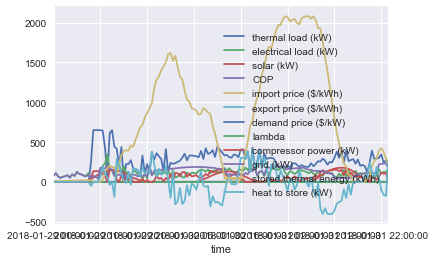

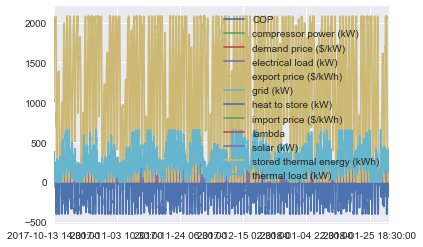

In [54]:
if logger.getEffectiveLevel() <= logging.DEBUG:
    trajectory_df.plot(); plt.show()
    output_df.plot(); plt.show()

In [55]:
forecast_output_file = r'.\data\{:04n}_interval_window.tsv'.format(FORECAST_INTERVALS)
forecast_result_filename = r'.\data\forecast_optimum_result.tsv'

forecast_output_df = pd.read_csv(forecast_output_file, sep='\t', index_col=0, infer_datetime_format=True, )

In [56]:
logger.info(forecast_output_df.index.name)

 2018-07-30 11:27:33,885 - INFO - None


In [57]:
forecast_output_df.index = pd.to_datetime(forecast_output_df.index)
forecast_output_df.index.name = 'time'

logger.info('old coulumn names:\n%s', forecast_output_df.columns)
forecast_output_df.rename(columns=OUTPUT_COLUMN_NAMES, inplace=True)
logger.info('new coulumn names:\n%s', forecast_output_df.columns)

 2018-07-30 11:27:34,409 - INFO - old coulumn names:
Index(['COP', 'compressor power (kW)', 'demand price ($/kW)',
       'electrical load (kW)', 'export price ($/kWh)', 'grid (kW)',
       'heat to store (kW)', 'import price ($/kWh)', 'lambda', 'mode',
       'solar (kW)', 'stored thermal energy (kWh)', 'thermal load (kW)'],
      dtype='object')
 2018-07-30 11:27:34,412 - INFO - new coulumn names:
Index(['CoP', 'P_kWe', 'pi_d', 'L_kWe', 'pi_e', 'G_kWe', 'C_kWr', 'pi_i',
       'lambda_dpkWh', 'mode', 'S_kWe', 'SoC_kWhr', 'L_kWr'],
      dtype='object')


In [58]:
output_df_vb = forecast_output_df.copy()
output_df_vb.pi_i = FOCUS_DF.adj_cpkWh/100
output_df_vb.pi_e = FOCUS_DF.exp_cpkWh/100

In [59]:
output_df_vb.S_kWe = FOCUS_DF.PV
over_export = output_df_vb.G_kWe < -output_df_vb.S_kWe

In [60]:
output_df_vb.G_kWe.loc[over_export] = -1*(
    output_df_vb.S_kWe.loc[over_export] +
    output_df_vb.G_kWe.loc[over_export] )

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [61]:
forecast_result_filename

'.\\data\\forecast_optimum_result.tsv'

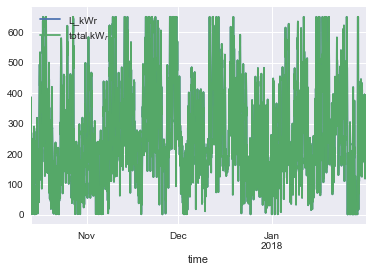

In [62]:
forecast_output_df.L_kWr.plot()
(forecast_output_df.P_kWe*forecast_output_df.CoP + forecast_output_df.C_kWr).plot(label='total kW$_r$')
plt.legend()
plt.show()

then this! 

In [63]:
(result_df, monthly_df) = calculate_costs(output_df_vb, forecast_result_filename)

 2018-07-30 11:27:39,258 - INFO - energy cost details:
PV only		PV+Storage	Saving
$50574.24	$46357.63	$4216.62

 2018-07-30 11:27:39,260 - INFO - demand cost details:
PV only		PV+Storage	Saving
$10045.74	$7847.28	$2198.46

 2018-07-30 11:27:39,262 - INFO - costs savings:
PV only		PV+Storage	Saving
$60619.98	$54204.90	$6415.08



In [64]:
plot_result_df(result_df)

In [65]:
monthly_df

,cost_e,cost_PV_only_e,cost_d,cost_pv_only_d
time,,,,
2017-10-31,4552.051527,4998.274718,1012.037218,1246.456091
2017-11-30,14175.580763,15008.974408,2408.644584,3001.374388
2017-12-31,9956.833181,10253.818200,2286.822496,2905.847584
2018-01-31,17673.160657,20313.175853,2139.773437,2892.061919


In [66]:
result_df0.S_kWe.max()

287.70499999999998

In [67]:
result_df.S_kWe.max()

287.70474999999988

In [68]:
6415/60619

0.10582490638248734

In [69]:
7813/60619

0.12888698262920867